In [1]:
import os
import numpy as np
import cv2 as cv
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tqdm import tqdm
import matplotlib.pyplot as plt
import json

In [2]:
label_maps = {'A':0, 'B':1, 'C':2, 'D':3, 'E':4, 'F':5, 'G':6, 'H':7, 'I':8, 'J':9, 'K':10, 'L':11, 'M':12, 'N':13, 'O':14, 'P':15, 'Q':16, 'R':17, 'S':18, 'T':19, 'U':20, 'V':21, 'W':22, 'X':23, 'Y':24, 'Z':25, 'del':26, 'nothing':27, 'space':28} 
images = []
labels = []
TRAIN_PATH= './asl_dataset/asl_alphabet_train/asl_alphabet_train'
TEST_PATH= './asl_dataset/asl_alphabet_test'

In [3]:
image_scale_factor = 64
for _, subdirs, _ in os.walk(TRAIN_PATH):
    if(subdirs):
        subdirs.sort()
        for i in subdirs:
            label = label_maps[i]
            IMAGES_PATH = TRAIN_PATH+'/'+i
            for _, _, files in os.walk(IMAGES_PATH):
                for image in tqdm(files, desc=i, ncols=100):
                    img = cv.imread(IMAGES_PATH+'/'+image)
                    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
                    width = int(img.shape[1] * image_scale_factor / 100)
                    height = int(img.shape[0] * image_scale_factor / 100)
                    re_img = cv.resize(img, (width, height), interpolation = cv.INTER_AREA)
                    images.append(np.asarray(re_img))
                    labels.append(label)
 
training_images, testing_images, training_labels, testing_labels = train_test_split(images, labels, test_size = 0.20)
depth = 29

training_images, testing_images = np.array(training_images) / 255.0, np.array(testing_images) / 255.0
training_labels, testing_labels = np.array(training_labels), np.array(testing_labels)

print(np.array(training_images).shape, np.array(testing_images).shape)
print(np.array(training_labels).shape, np.array(testing_labels).shape)

space: 100%|███████████████████████████████████████████████████| 3000/3000 [00:03<00:00, 922.13it/s]


(69600, 128, 128) (17400, 128, 128)
(69600,) (17400,)


In [4]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(29))

model.summary()

2021-11-24 17:27:56.391823: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       147584    
                                                                 
 flatten (Flatten)           (None, 100352)            0

In [5]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

print("finished compiling")

checkpoint_path = "./training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit(
    np.array(training_images), 
    np.array(training_labels), 
    epochs=10, 
    validation_data=(testing_images, testing_labels),
    callbacks=[cp_callback]
)

finished compiling
Epoch 1/10
2175/2175 [==============================] - ETA: 0s - loss: 0.9992 - accuracy: 0.6958
Epoch 00001: saving model to ./training/cp.ckpt
2175/2175 [==============================] - 1600s 735ms/step - loss: 0.9992 - accuracy: 0.6958 - val_loss: 0.2756 - val_accuracy: 0.9072
Epoch 2/10
2175/2175 [==============================] - ETA: 0s - loss: 0.1773 - accuracy: 0.9412
Epoch 00002: saving model to ./training/cp.ckpt
2175/2175 [==============================] - 1403s 645ms/step - loss: 0.1773 - accuracy: 0.9412 - val_loss: 0.1277 - val_accuracy: 0.9570
Epoch 3/10
2175/2175 [==============================] - ETA: 0s - loss: 0.1017 - accuracy: 0.9675
Epoch 00003: saving model to ./training/cp.ckpt
2175/2175 [==============================] - 1452s 667ms/step - loss: 0.1017 - accuracy: 0.9675 - val_loss: 0.1355 - val_accuracy: 0.9556
Epoch 4/10
2175/2175 [==============================] - ETA: 0s - loss: 0.0797 - accuracy: 0.9751
Epoch 00004: saving model to ./

In [6]:
print(json.dumps(history.history, indent=2))

{
  "loss": [
    0.9992026686668396,
    0.17725344002246857,
    0.10165049880743027,
    0.07970982044935226,
    0.060375627130270004,
    0.05076289921998978,
    0.03919560834765434,
    0.03436839580535889,
    0.032864782959222794,
    0.024052191525697708
  ],
  "accuracy": [
    0.6958333253860474,
    0.9412212371826172,
    0.9674712419509888,
    0.9750718474388123,
    0.9813506007194519,
    0.9855316281318665,
    0.9877011775970459,
    0.9898563027381897,
    0.9896839261054993,
    0.9928879141807556
  ],
  "val_loss": [
    0.2756151556968689,
    0.12767861783504486,
    0.13548307120800018,
    0.10174012929201126,
    0.08972543478012085,
    0.06200967729091644,
    0.05340709164738655,
    0.04575282335281372,
    0.06077249348163605,
    0.08003077656030655
  ],
  "val_accuracy": [
    0.9072414040565491,
    0.9569540023803711,
    0.9555746912956238,
    0.9701724052429199,
    0.9736207127571106,
    0.9818965792655945,
    0.9839655160903931,
    0.9889080

544/544 - 112s - loss: 0.0800 - accuracy: 0.9760 - 112s/epoch - 206ms/step
test loss:  0.08003077656030655 test accuracu:  0.9760344624519348


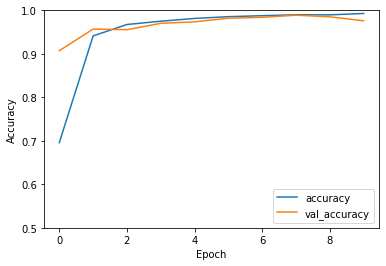

In [7]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(accuracy, label='accuracy')
plt.plot(val_accuracy, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc="lower right")

test_loss, test_acc = model.evaluate(testing_images,  testing_labels, verbose=2)
print('test loss: ', test_loss, 'test accuracu: ', test_acc)

asl_alphabet_test: 100%|███████████████████████████████████████████| 28/28 [00:00<00:00, 490.24it/s]
/var/folders/3x/44n5q91s11s0c3p7qhk7wdg00000gn/T/ipykernel_82608/1573181545.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


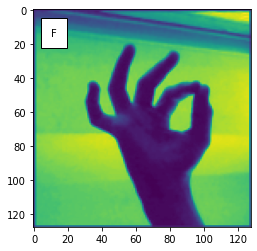

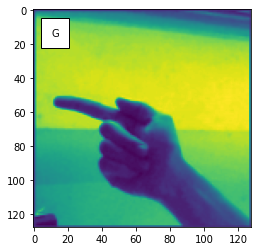

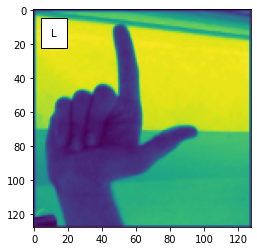

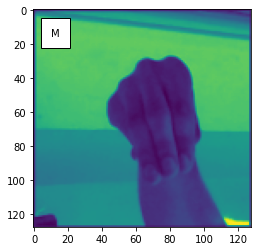

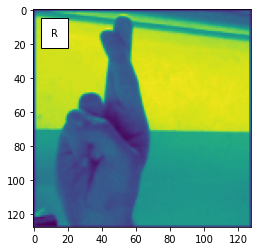

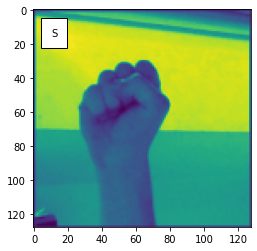

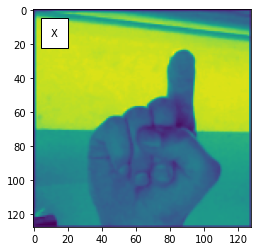

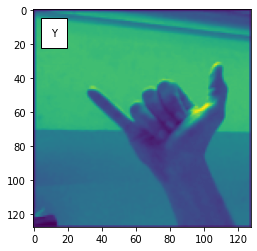

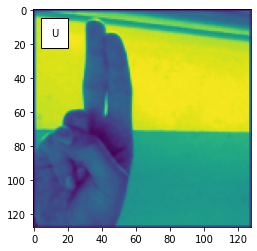

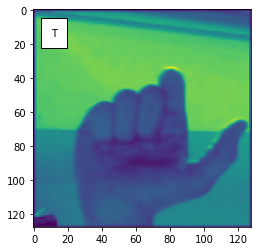

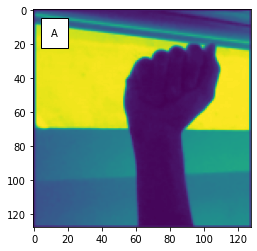

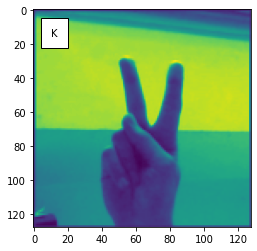

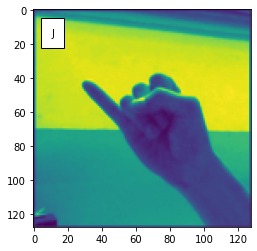

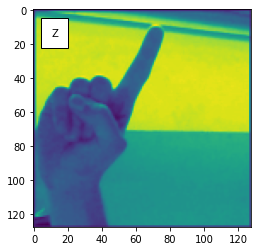

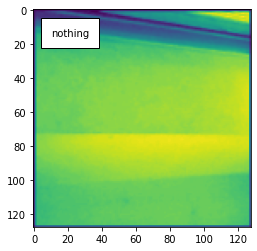

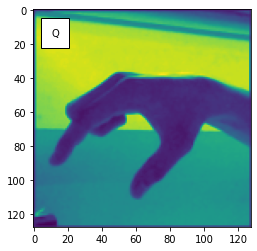

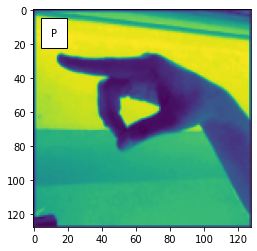

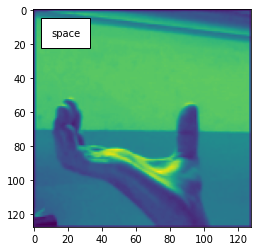

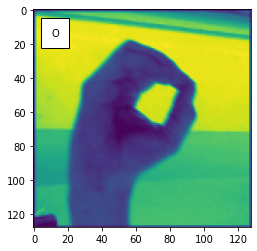

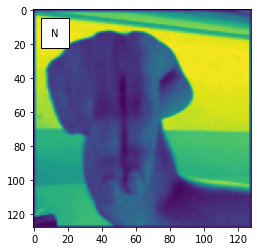

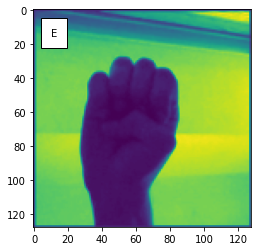

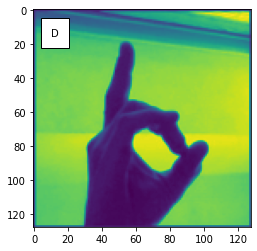

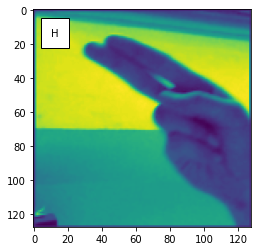

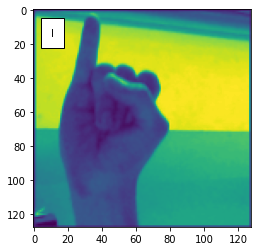

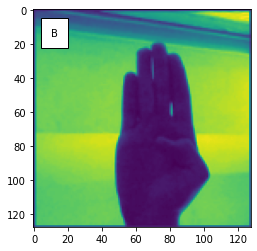

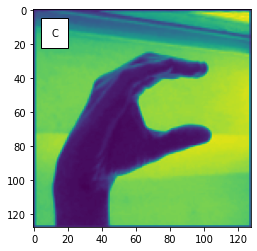

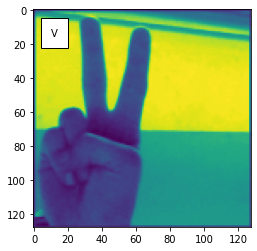

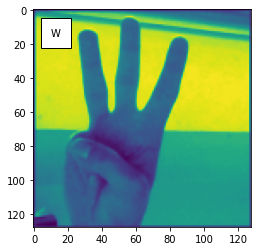

In [8]:
test_images = []
for _, subdirs, _ in os.walk(TEST_PATH):
    if(subdirs):
        subdirs.sort()
        for i in subdirs:
            IMAGES_PATH = TEST_PATH+'/'+i
            for _, _, files in os.walk(IMAGES_PATH):
                for image in tqdm(files, desc=i, ncols=100):
                    img = cv.imread(IMAGES_PATH+'/'+image)
                    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
                    width = int(img.shape[1] * image_scale_factor / 100)
                    height = int(img.shape[0] * image_scale_factor / 100)
                    re_img = cv.resize(img, (width, height), interpolation = cv.INTER_AREA)
                    test_images.append(np.asarray(re_img))

test_images = np.array(test_images) / 255.0
predictions = model.predict(test_images)
for i in range(len(predictions)):
    plt.figure()
    plt.imshow(test_images[i])
    prediction = (predictions[i].tolist()).index(max(predictions[i]))
    plt.text(10, 15, list(label_maps.keys())[list(label_maps.values()).index(prediction)], bbox={'facecolor': 'white', 'pad': 10})